# $K$-Medoids++, $K$-Means++, and Image Clustering

Guilherme Franca <guifranca@gmail.com>, 08/30/2016

Abstract: We implement $K$-medoids algorithm and compare it to $K$-means. We use the same idea as $K$-means++ for initialization. Furthermore, we allow both algorithms to work with an arbitrary distance function. We compare our implementation with $K$-means implementation from *scikit-learn* library. We evaluate both algorithms on image clustering with the MNIST dataset.

## A Bit of Theory

We implement both $K$-medoids and $K$-means to work with arbitrary distance function, as explained below.

### $K$-Medoids

$K$-medoids algorithm is very similar to $K$-means with the exception that instead of getting a mean of the points inside the cluster, we pick the *medoid*. A medoid is a data point whose average dissimilarity to all objects in the cluster is minimal. In other words, it's the closest data point to the center of the data in that cluster.

Compared to $K$-means it is more robust to noise and to outliers.

The algorithm is described as follows. Consider a distance function $\mathcal{V}(x_i, x_j)$
between data points $X = \{x_i\}_{i=1}^N$. Let
$$
z_{nk} = \begin{cases}
1 & \mbox{if $x_n \in C_k$} \\
0 & \mbox{otherwise}
\end{cases}
$$
where $C_k$, $k=1,\dotsc,K$, represents the $k$th cluster. We want to minimize the cost function
$$
J = \dfrac{1}{2}\sum_{n=1}^N \sum_{k=1}^K z_{nk} \mathcal{V}(x_n, m_k)
$$
where $m_k$ is the $k$th medoid of cluster $k$. We do this as follows:
    
1. Given a data set $X$, compute the distance matrix $D \in \mathbb{R}^{N \times N}$ between data points.
2. Initialize medoids $\{m_1, \dotsc, m_K\}$.
3. $Z$-update: 
$$
z_{nk} = \begin{cases} 
1 & \mbox{ if $k = \mbox{argmin}_{j} \mathcal{V}(x_n, m_j)$ } \\ 
0 & \mbox{otherwise}
\end{cases}
$$

4. $M$-update:
$$
m_k = \mbox{argmin}_{x_l \in C_k}\left\{ \dfrac{1}{n_k} \sum_{x_i \in C_k} \mathcal{V}(x_l,x_i)\right\}
$$
5. Repeat 3 and 4 until convergence.

Notice that we just need to compute distance between data points, thus we can compute a distance matrix $D_{ij} = \mathcal{V}(x_i, x_j)$ and implement this algorithm just working with the indices of the data points.

Moreover, we can choose the initialization step 2 in the same way as $K$-means++. 

This implementation can be found on file **kmedoids.py**.
    

### $K$-Means

The $K$-means algorithm with arbitrary distance function works in the same way, except that we compute the
distance of data points to the mean of each cluster.
We want to minimize the *distortion measure*
$$
J = \dfrac{1}{2} \sum_{n=1}^N\sum_{k=1}^K z_{nk} \mathcal{V}\left(x_n, \mu_k\right) 
$$
which is the sum of intra-cluster distances. We solve this through an iterative procedure consisting of two steps. First, 
$$
z_{nk} = \begin{cases} 
1 & \mbox{if $k=\mbox{argmin}_j \mathcal{V} \left( x_n, \mu_j \right) $}  \\
0 & \mbox{otherwise}
\end{cases}
$$
Second, 
$$
\mu_k = \dfrac{1}{N_k} \sum_{n=1}^N z_{nk} x_n
$$
where $N_k = \sum_{n=1}^N z_{nk}$ is the number of points associated to cluster $C_k$. 

### Initialization 

Below we denote $\mu_k$ the center of the $k$th cluster. For $K$-means this is the mean of points in the cluster, while for $K$-medoids this is a point in the data set.

1. Choose $\mu_1$ at random from $\{ x_n \}$.
2. For each $x_n$, assign the value $d_n = \min\{\mathcal{V}(x_n,\mu_1), \dotsc, D(x_n,\mu_k)\}$, where $k \le K$ is the number of centers already chosen at this stage.
3. Form a probability vector $p \in \mathbb{R}^N$ out of $\{d_n\}$ such that $p_n = d_n / \sum_{j=1}^{N} d_j$. Choose $\mu_k$ at random from $\{ x_n \}$ with probability distribution given by $p$.
4. Repeat until $k=K$.

## Comparison $K$-Medoids and $K$-Means for Gaussian Clusters

In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import datasets
from sklearn import metrics
from sklearn.cluster import KMeans

import kmedoids
import kmeans
import clusval
import distance

golden = (1+np.sqrt(5))/2

In [19]:
# artificial data from normal distributions
mean = np.array([0,0])
cov = np.array([[4,0], [0,1]])
data1 = np.random.multivariate_normal(mean, cov, 200)
mean = np.array([3,5])
cov = np.array([[1,0.8], [0.8,2]])
data2 = np.random.multivariate_normal(mean, cov, 200)
mean = np.array([-2,3])
cov = np.array([[0.5,0], [0,0.5]])
data3 = np.random.multivariate_normal(mean, cov, 200)
data = np.concatenate((data1, data2, data3))
labels = np.concatenate(([0]*200, [1]*200, [2]*200))

In [20]:
# K-medoids
K=3
D = distance.euclidean_matrix(data)
J, M = kmedoids.kmedoids(K, D)

In [21]:
# Our own implementation of K-means
K=3
JJ, MM = kmeans.kmeans(K, data, distance.euclidean)

In [22]:
# Scikit-Learn K-means
K=3
km = KMeans(K)
r = km.fit(data)
JJJ = r.labels_

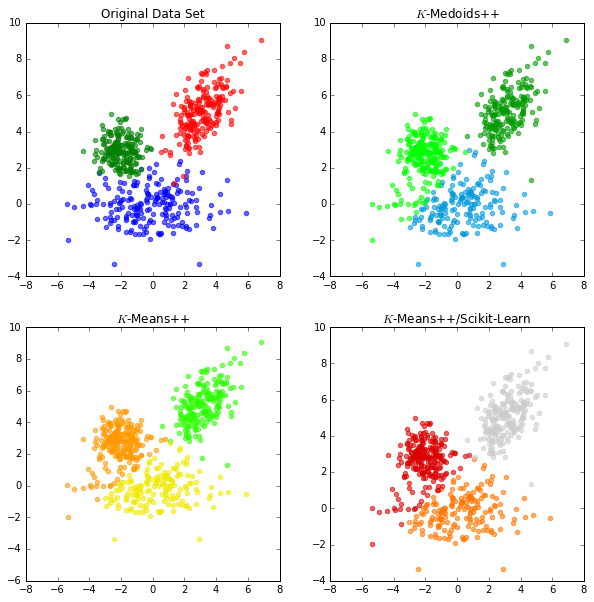

In [23]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(221)
ax.scatter(data1[:,0], data1[:,1], color='b', alpha=.6)
ax.scatter(data2[:,0], data2[:,1], color='r', alpha=.6)
ax.scatter(data3[:,0], data3[:,1], color='g', alpha=.6)
ax.set_title('Original Data Set')

ax = fig.add_subplot(222)
cc = cm.spectral(np.linspace(0.3,0.6,K))
for k in range(K):
    idx = np.where(J==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Medoids++')
    
ax = fig.add_subplot(223)
cc = cm.spectral(np.linspace(0.61,0.8,K))
for k in range(K):
    idx = np.where(JJ==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Means++')

ax = fig.add_subplot(224)
cc = cm.spectral(np.linspace(0.81,1,K))
for k in range(K):
    idx = np.where(JJJ==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Means++/Scikit-Learn')

In [24]:
# mutual information (unnormalized)
print metrics.mutual_info_score(labels, J)
print metrics.mutual_info_score(labels, JJ)
print metrics.mutual_info_score(labels, JJJ)
print
# normalized NMI
print metrics.normalized_mutual_info_score(labels, J)
print metrics.normalized_mutual_info_score(labels, JJ)
print metrics.normalized_mutual_info_score(labels, JJ)
print
# adjusted MI, this is not so common
print metrics.adjusted_mutual_info_score(labels, J)
print metrics.adjusted_mutual_info_score(labels, JJ)
print metrics.adjusted_mutual_info_score(labels, JJJ)
print
# ARI (adjusted Rand Index)
print metrics.adjusted_rand_score(labels, J)
print metrics.adjusted_rand_score(labels, JJ)
print metrics.adjusted_rand_score(labels, JJJ)
print
# Misclassification Error
print clusval.class_error(labels, J)
print clusval.class_error(labels, JJ)
print clusval.class_error(labels, JJJ)

0.878160893199
0.880564248997
0.888691764532

0.802589657978
0.804765213271
0.804765213271

0.798723032533
0.800917348587
0.808337950813

0.812332105117
0.819689420005
0.824127032731

0.0683333333333
0.065
0.0633333333333


In this case both $K$-medoids and $K$-means seem to be clustering with very close accuracy.

In the next plots we choose a range of $N$, the number of data points. For each time we randomly generate data from normal distributions with the same parameters as before, then we run the algorithms few times and calculate the average score, and the maximum and the minimum to plot error bars.

In [32]:
nrange = range(10, 300, 10)
kmedoids_metric, kmeans_metric, kmeans_sklearn_metric = clusval.gauss_eval(distance.euclidean_matrix, distance.euclidean, metrics.normalized_mutual_info_score, nrange, num_avg=7)

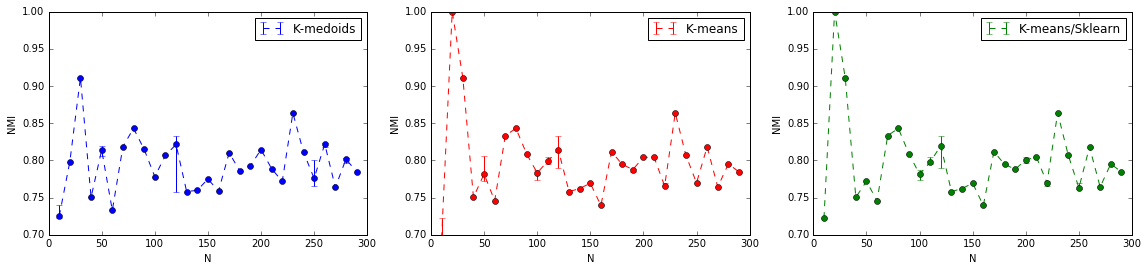

In [36]:
def errplot(ax, xs, data, label, color, ylabel, yrange=[0.7,1]):
    a = np.array(data)
    mean = a[:,0]
    lower = mean - a[:,1]
    upper = a[:,2] - mean
    error = [lower, upper]
    ax.errorbar(xs, mean, yerr=error, label=label, color=color, ls='dashed')
    ax.plot(xs, mean, 'o', color=color)
    ax.set_ylim(yrange)
    ax.set_xlabel('N')
    ax.set_ylabel(ylabel)
    ax.legend(loc=0)

fig = plt.figure(figsize=(4*golden*3,4))
ax = fig.add_subplot(131)
errplot(ax, nrange, kmedoids_metric, 'K-medoids', 'blue', 'NMI')
ax1 = fig.add_subplot(132, sharex=ax)
errplot(ax1, nrange, kmeans_metric, 'K-means', 'red', 'NMI')
ax2 = fig.add_subplot(133, sharex=ax)
errplot(ax2, nrange, kmeans_sklearn_metric, 'K-means/Sklearn', 'green', 'NMI')

In [42]:
nrange = range(10, 300, 10)
kmedoids_metric, kmeans_metric, kmeans_sklearn_metric = clusval.gauss_eval(distance.euclidean_matrix, distance.euclidean, clusval.class_error, nrange, num_avg=7)

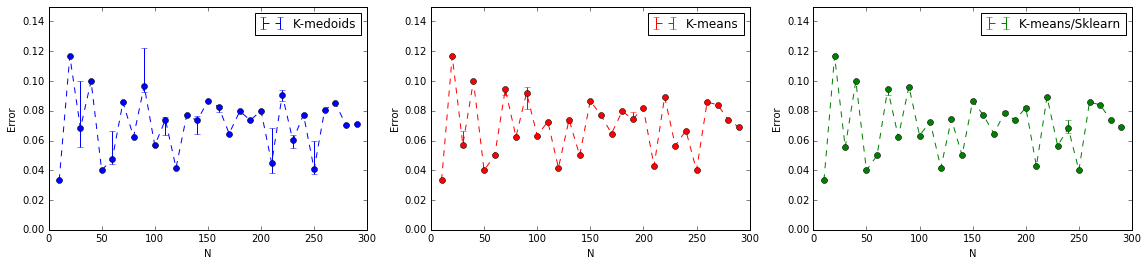

In [46]:
fig = plt.figure(figsize=(4*golden*3,4))
ax = fig.add_subplot(131)
errplot(ax, nrange, kmedoids_metric, 'K-medoids', 'blue', 'Error', yrange=[0,0.15])
ax1 = fig.add_subplot(132, sharex=ax)
errplot(ax1, nrange, kmeans_metric, 'K-means', 'red', 'Error', yrange=[0,0.15])
ax2 = fig.add_subplot(133, sharex=ax)
errplot(ax2, nrange, kmeans_sklearn_metric, 'K-means/Sklearn', 'green', 'Error', yrange=[0,0.15])

## Comparing $K$-Medoids and $K$-Means for Iris Dataset

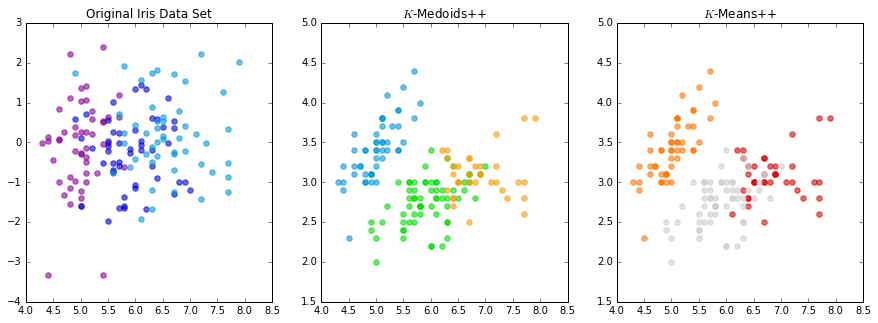

In [47]:
# using the iris data set

iris = datasets.load_iris()
iris_data = iris.data
iris_label = iris.target

K = 3
J, M = kmedoids.kmedoids(K, distance.euclidean_matrix(iris_data))
JJ, MM = kmeans.kmeans(K, iris_data, distance.euclidean)

fig = plt.figure(figsize=(15,5))

s = 30 #marker size
ax = fig.add_subplot(131)
cc = cm.spectral(np.linspace(0.1, 0.3, K))
for k in range(K):
    idx = np.where(iris_label==k)
    ax.scatter(iris_data[:,0][idx], data1[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('Original Iris Data Set')

ax = fig.add_subplot(132)
cc = cm.spectral(np.linspace(0.3,0.8,K))
for k in range(K):
    idx = np.where(J==k)
    ax.scatter(iris_data[:,0][idx], iris_data[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('$K$-Medoids++')
    
ax = fig.add_subplot(133)
cc = cm.spectral(np.linspace(0.81,1,K))
for k in range(K):
    idx = np.where(JJ==k)
    ax.scatter(iris_data[:,0][idx], iris_data[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('$K$-Means++')

In [50]:
labels = iris_label

print "MI (unnormalized)"
print metrics.mutual_info_score(labels, J)
print metrics.mutual_info_score(labels, JJ)
print
print "normalized NMI"
print metrics.normalized_mutual_info_score(labels, J)
print metrics.normalized_mutual_info_score(labels, JJ)
print
print "adjusted MI, this is not so common"
print metrics.adjusted_mutual_info_score(labels, J)
print metrics.adjusted_mutual_info_score(labels, JJ)
print
print "ARI"
print metrics.adjusted_rand_score(labels, J)
print metrics.adjusted_rand_score(labels, JJ)
print
print "Misclassification Error"
print clusval.class_error(labels, J)
print clusval.class_error(labels, JJ)

MI (unnormalized)
0.864523826966
0.82559109761

normalized NMI
0.798067420537
0.758205727819

adjusted MI, this is not so common
0.784252780334
0.74837231318

ARI
0.74550386818
0.730238272283

Misclassification Error
0.1
0.106666666667


## Comparing $K$-Medoids and $K$-Means for MNIST Dataset

In [51]:
digits = datasets.load_digits()
images = digits.images
print images.shape

(1797, 8, 8)


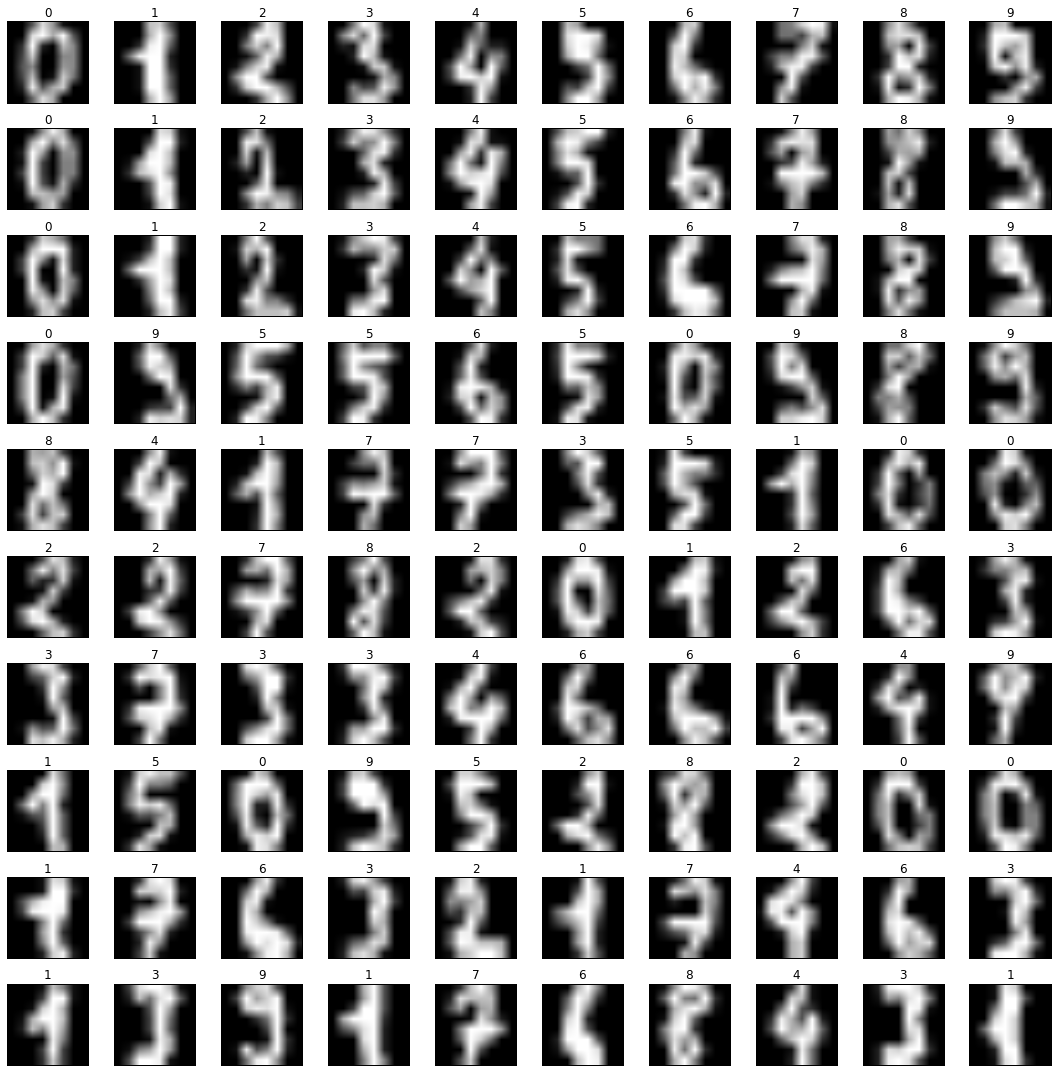

In [52]:
# showing a sample of the figures
fig = plt.figure(figsize=(15,15))
for i, img in enumerate(images[:100]):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(img, cmap=cm.gray)
    ax.set_title("%i" % digits.target[i])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

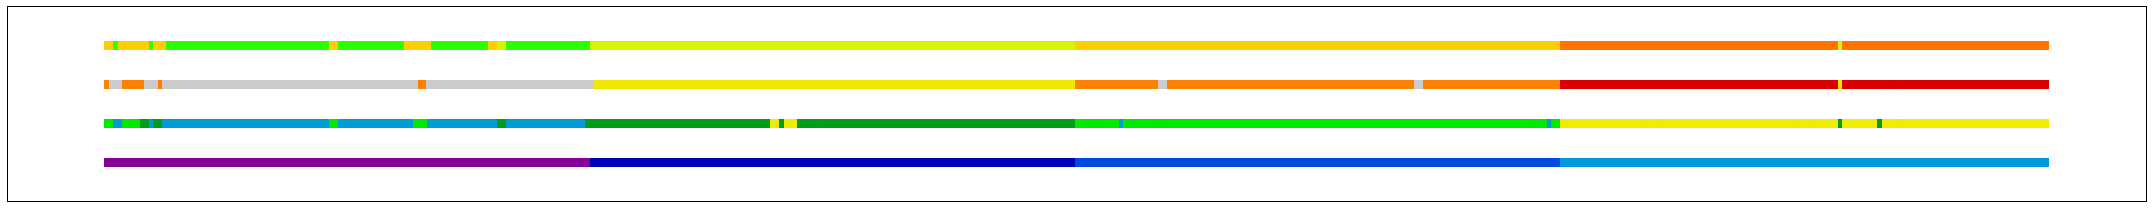

In [75]:
# picking some digits
n = [110, 110, 110, 110]
d = [2, 7, 8, 4]
labels = np.concatenate([[i]*x for i, x in enumerate(n)])

data = np.concatenate([images[np.where(digits.target==i)][:m] for i, m in zip(d, n)])
data2 = data.reshape((len(data), 64))

# just to plot points and visualize data
coords = np.array([i for i in range(len(data))])

J, M = kmedoids.kmedoids(len(n), distance.euclidean_matrix(data2))
JJ, MM = kmeans.kmeans(len(n), data2, distance.euclidean)
km = KMeans(len(n))
JJJ = km.fit(data2).labels_

fig = plt.figure(figsize=(30,3))
ax = fig.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
cc = cm.spectral(np.linspace(0.1, 0.3, len(n)))
s = 50
for k in range(len(n)):
    idx = np.where(labels==k)[0]
    ax.scatter(coords[idx], [0]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.31, 0.7, len(n)))
for k in range(len(n)):
    idx = np.where(J==k)[0]
    ax.scatter(coords[idx], [1]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.71, 1, len(n)))
for k in range(len(n)):
    idx = np.where(JJ==k)[0]
    ax.scatter(coords[idx], [2]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.61, 0.81, len(n)))
for k in range(len(n)):
    idx = np.where(JJJ==k)[0]
    ax.scatter(coords[idx], [3]*len(idx), color=cc[k], s=s, marker='s')
    
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-1, 4)
fig.tight_layout()


The above figure show a colored square for each digit category. The bottom dots are the true digits, the second line of dots are the digits clustered by $K$-medoids++, and the top 2 lines of dots using $K$-means++, from our implementation and scikit-learn, respectivelly.

In [76]:
print "MI (unnormalized)"
print metrics.mutual_info_score(labels, J)
print metrics.mutual_info_score(labels, JJ)
print metrics.mutual_info_score(labels, JJJ)
print
print "NMI"
print metrics.normalized_mutual_info_score(labels, J)
print metrics.normalized_mutual_info_score(labels, JJ)
print metrics.normalized_mutual_info_score(labels, JJJ)
print
print "adjusted MI, this is not so common"
print metrics.adjusted_mutual_info_score(labels, J)
print metrics.adjusted_mutual_info_score(labels, JJ)
print metrics.adjusted_mutual_info_score(labels, JJJ)
print
print "ARI"
print metrics.adjusted_rand_score(labels, J)
print metrics.adjusted_rand_score(labels, JJ)
print metrics.adjusted_rand_score(labels, JJJ)
print
print "Misclassification Error"
print clusval.class_error(labels, J)
print clusval.class_error(labels, JJ)
print clusval.class_error(labels, JJJ)

MI (unnormalized)
1.04616183175
1.17333342753
1.17192195348

NMI
0.755045333908
0.848032763929
0.846560173995

adjusted MI, this is not so common
0.752804675455
0.845228026054
0.844202261708

ARI
0.788351767046
0.85133623759
0.847373572248

Misclassification Error
0.0840909090909
0.0590909090909
0.0613636363636


## Evaluating $K$-Medoids++ and $K$-Means++ on MNIST

Now we evaluate the above clustering more systematically. We analyse several metric indices against $N$, the size of the data set. We also run the algorithm several times and take the average result.


In [85]:
numbers = [2, 5, 8]
nrange = range(10, 170, 10)
kmedoids_metric, kmeans_metric, kmeans_sklearn_metric = clusval.MNIST_eval_euclidean(metrics.normalized_mutual_info_score, numbers, nrange, num_avg=7)

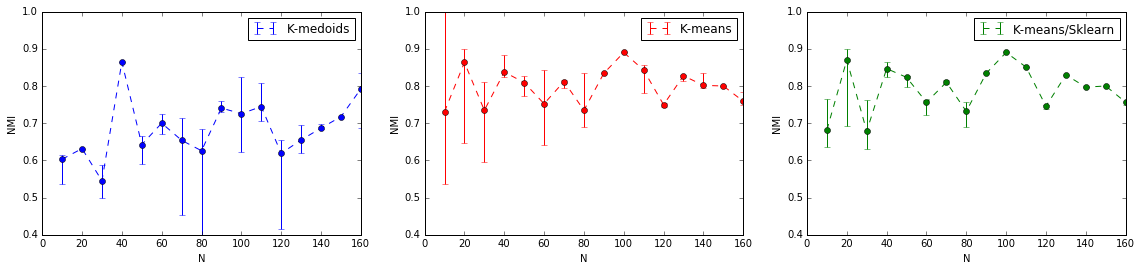

In [87]:
def errplot(ax, xs, data, label, color, ylabel, yrange=[0.4,1]):
    a = np.array(data)
    mean = a[:,0]
    lower = mean - a[:,1]
    upper = a[:,2] - mean
    error = [lower, upper]
    ax.errorbar(xs, mean, yerr=error, label=label, color=color, ls='dashed')
    ax.plot(xs, mean, 'o', color=color)
    ax.set_ylim(yrange)
    ax.set_xlabel('N')
    ax.set_ylabel(ylabel)
    ax.legend(loc=0)

fig = plt.figure(figsize=(4*golden*3,4))
ax = fig.add_subplot(131)
errplot(ax, nrange, kmedoids_metric, 'K-medoids', 'blue', 'NMI')
ax1 = fig.add_subplot(132, sharex=ax)
errplot(ax1, nrange, kmeans_metric, 'K-means', 'red', 'NMI')
ax2 = fig.add_subplot(133, sharex=ax)
errplot(ax2, nrange, kmeans_sklearn_metric, 'K-means/Sklearn', 'green', 'NMI')

In [88]:
numbers = [2, 5, 8]
nrange = range(10, 170, 10)
kmedoids_metric, kmeans_metric, kmeans_sklearn_metric = clusval.MNIST_eval_euclidean(clusval.class_error, numbers, nrange, num_avg=7)

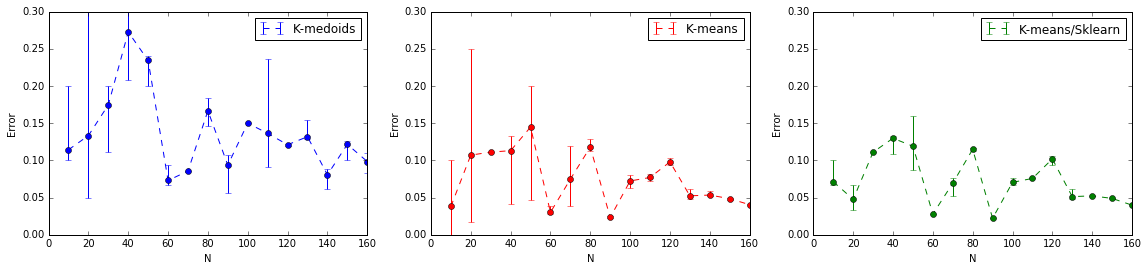

In [91]:
fig = plt.figure(figsize=(4*golden*3,4))
ax = fig.add_subplot(131)
errplot(ax, nrange, kmedoids_metric, 'K-medoids', 'blue', 'Error', yrange=[0,.3])
ax1 = fig.add_subplot(132, sharex=ax)
errplot(ax1, nrange, kmeans_metric, 'K-means', 'red', 'Error', yrange=[0,.3])
ax2 = fig.add_subplot(133, sharex=ax)
errplot(ax2, nrange, kmeans_sklearn_metric, 'K-means/Sklearn', 'green', 'Error', yrange=[0,.3])

In [94]:
n = [170, 170, 170, 170]
d = [2, 7, 8, 4]
labels = np.concatenate([[i]*x for i, x in enumerate(n)])

data = np.concatenate([
        images[np.where(digits.target==i)][np.random.choice(range(173), m)] 
        for i, m in zip(d, n)
])
data2 = data.reshape((len(data), 64))

print "Euclidean Distance on Vectors"
J, M = kmeans.kmeans(len(n), data2, distance.euclidean, numtimes=10)
print clusval.class_error(labels, J)
print
print "Frobenius Norm on Matrix"
J, M = kmeans.kmeans(len(n), data, lambda a, b: np.linalg.norm(a-b, ord='fro'), numtimes=10)
print clusval.class_error(labels, J)
print
print "Nuclear Norm on Matrix"
J, M = kmeans.kmeans(len(n), data, lambda a, b: np.linalg.norm(a-b, ord='nuc'), numtimes=10)
print clusval.class_error(labels, J)
print
print "2 Norm - Largest Singular Value"
J, M = kmeans.kmeans(len(n), data, lambda a, b: np.linalg.norm(a-b, ord=2), numtimes=10)
print clusval.class_error(labels, J)

Euclidean Distance on Vectors
0.0602941176471

Frobenius Norm on Matrix
0.0529411764706

Nuclear Norm on Matrix
0.0794117647059

2 Norm - Largest Singular Value
0.139705882353


In [95]:
n = [170, 170, 170, 170]
d = [1, 7, 8, 4]
labels = np.concatenate([[i]*x for i, x in enumerate(n)])

data = np.concatenate([
        images[np.where(digits.target==i)][np.random.choice(range(173), m)] 
        for i, m in zip(d, n)
])
data2 = data.reshape((len(data), 64))

print "Euclidean Distance on Vectors"
J, M = kmeans.kmeans(len(n), data2, distance.euclidean, numtimes=10)
print clusval.class_error(labels, J)
print
print "Frobenius Norm on Matrix"
J, M = kmeans.kmeans(len(n), data, lambda a, b: np.linalg.norm(a-b, ord='fro'), numtimes=10)
print clusval.class_error(labels, J)
print
print "Nuclear Norm on Matrix"
J, M = kmeans.kmeans(len(n), data, lambda a, b: np.linalg.norm(a-b, ord='nuc'), numtimes=10)
print clusval.class_error(labels, J)
print
print "2 Norm - Largest Singular Value"
J, M = kmeans.kmeans(len(n), data, lambda a, b: np.linalg.norm(a-b, ord=2), numtimes=10)
print clusval.class_error(labels, J)

Euclidean Distance on Vectors
0.208823529412

Frobenius Norm on Matrix
0.210294117647

Nuclear Norm on Matrix
0.238235294118

2 Norm - Largest Singular Value
0.175


In [107]:
n = [110]*5
d = [1,2,3,4,5]
labels = np.concatenate([[i]*x for i, x in enumerate(n)])

data = np.concatenate([
        images[np.where(digits.target==i)][np.random.choice(range(173), m)] 
        for i, m in zip(d, n)
])
data2 = data.reshape((len(data), 64))

print "Euclidean Distance on Vectors"
J, M = kmeans.kmeans(len(n), data2, distance.euclidean, numtimes=10)
print clusval.class_error(labels, J)
print
print "Frobenius Norm on Matrix"
J, M = kmeans.kmeans(len(n), data, lambda a, b: np.linalg.norm(a-b, ord='fro'), numtimes=10)
print clusval.class_error(labels, J)

Euclidean Distance on Vectors
0.201818181818

Frobenius Norm on Matrix
0.165454545455


In [108]:
n = [110]*5
d = [2,3,4,5,6]
labels = np.concatenate([[i]*x for i, x in enumerate(n)])

data = np.concatenate([
        images[np.where(digits.target==i)][np.random.choice(range(173), m)] 
        for i, m in zip(d, n)
])
data2 = data.reshape((len(data), 64))

print "Euclidean Distance on Vectors"
J, M = kmeans.kmeans(len(n), data2, distance.euclidean, numtimes=10)
print clusval.class_error(labels, J)
print
print "Frobenius Norm on Matrix"
J, M = kmeans.kmeans(len(n), data, lambda a, b: np.linalg.norm(a-b, ord='fro'), numtimes=10)
print clusval.class_error(labels, J)

Euclidean Distance on Vectors
0.0581818181818

Frobenius Norm on Matrix
0.0381818181818
